# Image Segmentation on Cityscapes data
### We will be applying image segmentation on cityscapes data using U-Net and Pytorch.

### Installing Pytorch
More information about installing pytorch can be found at https://pytorch.org/get-started/locally/

In [ ]:
#Imported Pytorch in Kaggle
!pip3 install torch torchvision torchaudio;

## Importing libraries

In [2]:
# System 
import os
import sys

# Data and image processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import cv2
from PIL import Image
import albumentations as A

# Pytorch libs
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset ,DataLoader
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F
from torch import from_numpy

## Creating main variables

In [3]:
train_directory= "/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/"
val_directory = "/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/"

train_img_names = os.listdir(train_directory)
val_img_names = os.listdir(val_directory)

## Visualizing training data

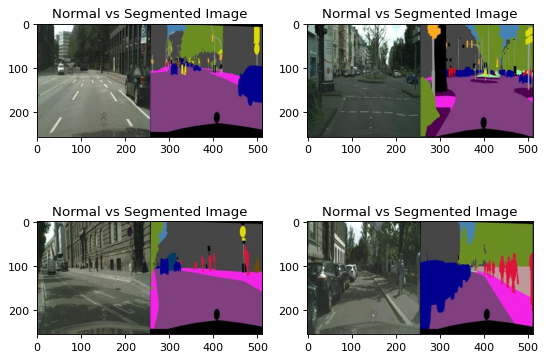

In [4]:
figure(figsize=(8, 6), dpi=80)
train_img_path = [os.path.join(train_directory + "/" + i) for i in train_img_names]
k=0
for i in train_img_path:
   
    k=k+1
    if k >= 5:
        break
    plt.subplot(2,2,k) 
    
    plt.imshow(mpimg.imread(i))
    plt.title("Normal vs Segmented Image")
plt.show()

### Inspecting data

In [5]:
for i in train_img_path:
    ig = cv2.imread(i)

shape = ig.shape
length = len(train_img_names)
print("Shape of combined images: ", shape)
print("No. of combined images: ", length)

Shape of combined images:  (256, 512, 3)
No. of combined images:  2975


### We can see from the above observations that -
        - Our normal and segmeted images are combined 
        - We do not have color encoded segemtation
        - Segmented images are in RGB format

### We will be using Kmeans algorithm to create clusters for our image and apply color encoding in the masks.

For more information on Kmeans please visit https://www.javatpoint.com/k-means-clustering-algorithm-in-machine-learning

In [6]:
# Preparing masks (segmetation for Kmeans)
kmeans_data = []
for img in train_img_names[0:50]:
    org_img = cv2.imread(os.path.join(train_directory, img))
    imgg = org_img[:, 0:256,:]
    msk = org_img[:, 256:,:]
    
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
kmeans_data = kmeans_data.reshape(-1,3)
print(kmeans_data.shape)

(3276800, 3)


In [7]:
# Importing and applying Kmeans
from sklearn.cluster import KMeans
encoder = KMeans(n_clusters=8)
encoder.fit(kmeans_data)

KMeans()

### Kmeans clusters

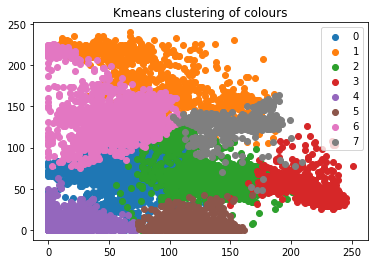

In [8]:
for img in train_img_names[0:1]:
    org_img = cv2.imread(os.path.join(train_directory, img))
    msk = org_img[:, 256:,:]
    test = msk.reshape(-1,3)
    pred = encoder.predict(test)
    u_labels = np.unique(pred)
    for i in u_labels:
        plt.scatter(test[pred == i , 0] , test[pred == i , 1] , label = i)
        plt.title("Kmeans clustering of colours")
    plt.legend()
    plt.show()

In [9]:
colors = {0: [255,0,0], #red
          1: [0,255,0], #green
          2: [0,0,255], #blue
          3: [128,0,0], #maroon
          4: [255,0,255], #magenta
          5: [0,128,128], #teal
          6: [255,255,0], #yellow
          7: [192,192,192], #silver
          }

### Encoding

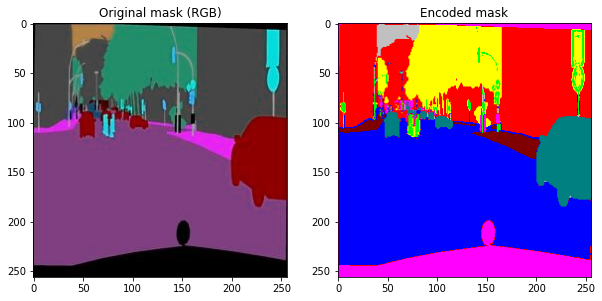

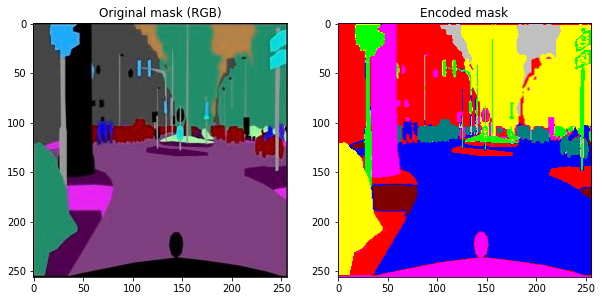

In [10]:
for img in train_img_names[0:2]:
    org_img = cv2.imread(os.path.join(train_directory, img))
    msk = org_img[:, 256:,:]
    test = msk.reshape(-1,3)
    pred = encoder.predict(test)
    
    enc_pred = pred.reshape(256, 256)
    
    pred = np.array([colors[p] for p in pred]).reshape(256,256,3)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(msk)
    plt.title('Original mask (RGB)')
    plt.subplot(1,2,2)
    plt.imshow(pred)
    plt.title('Encoded mask')
    plt.show()

## Creating dataset

In [11]:
class Dataset(Dataset):
    def __init__(self, images_list, size, mean = None, std = None):
        self.images_list = images_list
        self.size = size
        
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std
        
    def __len__(self):
        return len(os.listdir(self.images_list))

    def __getitem__(self, index):
        img = os.listdir(self.images_list)[index]
        pth = os.path.join(self.images_list, img)

        
          
        pil_image = Image.open(pth).convert('RGB')
        org_img = np.array(pil_image)
        
        np_image = org_img[:, 0:256,:]
        np_target = org_img[:, 256:,:] 
        
        test = (np_target.reshape(-1,3))      
        pred = encoder.predict(test)
        seg_msk = pred.reshape(256,256)
        
        
        
        trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])
            
        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor

### Creating dataset objects and trainloaders

In [12]:
train_data_obj = Dataset(train_directory, 256, mean=None, std=None)
train_dataloader = DataLoader(train_data_obj, batch_size=17, shuffle=True )

test_data_obj = Dataset(val_directory, 256, mean=None, std=None)
test_dataloader = DataLoader(test_data_obj, batch_size=10, shuffle=True)

test1_data_obj = Dataset(val_directory, 256, mean = None, std=None)
test1_dataloader = DataLoader(test1_data_obj, batch_size=1, shuffle=True)

## UNet Models

### Model 1
#### This is my implementation of UNet which works okay but other people have done customizations to make UNet work much better so I will be applying their implementation instead.

In [13]:
# def double_conv(in_c, out_c):
#     conv = nn.Sequential(
#         nn.Conv2d(in_c, out_c, kernel_size=3),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(out_c, out_c, kernel_size=3),
#         nn.ReLU(inplace=True))
#     return conv
    
    
    
# def crop_img(tensor, target_tensor):
#     target_size = target_tensor.size()[2]
#     tensor_size = tensor.size()[2]
#     delta = tensor_size - target_size
#     delta = delta // 2
#     return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]


# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
        
#         self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride = 2)
#         self.down_conv_1 = double_conv(3, 64)
#         self.b1 = nn.BatchNorm2d(64)
#         self.down_conv_2 = double_conv(64, 128)
#         self.b2 = nn.BatchNorm2d(128)

#         self.down_conv_3 = double_conv(128, 256)
#         self.b3 = nn.BatchNorm2d(256)

#         self.down_conv_4 = double_conv(256, 512)
#         self.b4 = nn.BatchNorm2d(512)

#         self.down_conv_5 = double_conv(512, 1024)
#         self.b5 = nn.BatchNorm2d(1024)

        
        
#         self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024,
#                                             out_channels=512,
#                                             kernel_size = 2,
#                                             stride=2)
        
#         self.up_conv_1 = double_conv(1024, 512)
#         self.b6 = nn.BatchNorm2d(512)

        
        
#         self.up_trans_2 = nn.ConvTranspose2d(in_channels=512,
#                                             out_channels=256,
#                                             kernel_size = 2,
#                                             stride=2)
        
#         self.up_conv_2 = double_conv(512, 256)
#         self.b7 = nn.BatchNorm2d(256)

        
        
#         self.up_trans_3 = nn.ConvTranspose2d(in_channels=256,
#                                             out_channels=128,
#                                             kernel_size = 2,
#                                             stride=2)
        
#         self.up_conv_3 = double_conv(256, 128)
#         self.b8 = nn.BatchNorm2d(128)

        
        
#         self.up_trans_4 = nn.ConvTranspose2d(in_channels=128,
#                                             out_channels=64,
#                                             kernel_size = 2,
#                                             stride=2)
        
#         self.up_conv_4 = double_conv(128, 64)
#         self.b9 = nn.BatchNorm2d(64)

        
#         self.out = nn.Conv2d(in_channels=64, out_channels=12, kernel_size=1)
        
        
        
        
        
        
#     def forward(self, image):
#         x1 = self.down_conv_1(image)
#         x1 = self.b1(x1)
#         x2 = self.max_pool_2x2(x1)
        
        
#         x3 = self.down_conv_2(x2)
#         x3 = self.b2(x3)
#         x4 = self.max_pool_2x2(x3)
        
        
#         x5 = self.down_conv_3(x4)
#         x5 = self.b3(x5)
#         x6 = self.max_pool_2x2(x5)
        
        
#         x7 = self.down_conv_4(x6)
#         x7 = self.b4(x7)
#         x8 = self.max_pool_2x2(x7)
        
        
#         x9 = self.down_conv_5(x8)
#         x9 = self.b5(x9)
        
#         x = self.up_trans_1(x9)
#         y = crop_img(x7, x)
#         x = self.up_conv_1(torch.cat([x, y], 1))
#         x = self.b6(x)
        
#         x = self.up_trans_2(x)
#         y = crop_img(x5, x)
#         x = self.up_conv_2(torch.cat([x, y], 1))
#         x=self.b7(x)
        
#         x = self.up_trans_3(x)
#         y = crop_img(x3, x)
#         x = self.up_conv_3(torch.cat([x, y], 1))
#         x = self.b8(x)
        
        
#         x = self.up_trans_4(x)
#         y = crop_img(x1, x)
#         x = self.up_conv_4(torch.cat([x, y], 1))
#         x = self.b9(x)
        
#         return x

### Model 2
#### This really amazing implementation of UNet is taken from https://github.com/jvanvugt/pytorch-unet

In [14]:
class UNetTunable(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
        conv_mode='standard'
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        
        super(UNetTunable, self).__init__()
        assert conv_mode in ('standard', 'dilated')
        assert up_mode in ('upconv', 'upsample', 'dilated')
        
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm,conv_mode)
            ).to(device)
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm,conv_mode)
            ).to(device)
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm,conv_mode):
        super(UNetConvBlock, self).__init__()
        
        if conv_mode == 'standard':
            block = []
            block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            self.block = nn.Sequential(*block)
            
        elif conv_mode == 'dilated':
            block = []
            block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding), dilation = 1 ))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding), dilation = 1 ))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm, conv_mode):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )
        elif up_mode == 'dilated':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm, conv_mode)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

### Instantiating our model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetTunable(in_channels=3,
                        n_classes=8,
                        depth=5,
                        wf=6,
                        padding=True,
                        batch_norm=True,
                        up_mode='upconv',
                        conv_mode='dilated'
                       ).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

## Optimizer

In [16]:
import torch.optim 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

## Loss

In [17]:
def compute_loss(y_hat, y):
    return F.cross_entropy(y_hat, y)

## Training loop

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(50):
    total_loss = 0
    
    for batch in train_dataloader:
        image, msk = batch
        mski = transforms.Resize(256)
        msk = mski(msk).long()


        

        image = image.to(device=device)
        label = msk.to(device=device)

        model.to(device)
        predicted = model(image)
        loss = compute_loss(predicted, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print("epoch: ", epoch, " loss: ", total_loss)

epoch:  0  loss:  152.3271017074585
epoch:  1  loss:  114.22559863328934
epoch:  2  loss:  100.58623108267784
epoch:  3  loss:  91.91580656170845
epoch:  4  loss:  87.19884866476059
epoch:  5  loss:  83.95021095871925
epoch:  6  loss:  81.08739429712296
epoch:  7  loss:  77.08133289217949
epoch:  8  loss:  74.48136726021767
epoch:  9  loss:  72.41805717349052
epoch:  10  loss:  69.37263441085815
epoch:  11  loss:  68.01868391036987
epoch:  12  loss:  65.82701361179352
epoch:  13  loss:  62.925375044345856
epoch:  14  loss:  61.3036148250103
epoch:  15  loss:  58.740187615156174
epoch:  16  loss:  56.19639714062214
epoch:  17  loss:  54.11333802342415
epoch:  18  loss:  51.08644495904446
epoch:  19  loss:  49.87181532382965
epoch:  20  loss:  47.42564445734024
epoch:  21  loss:  44.780349254608154
epoch:  22  loss:  42.492672085762024
epoch:  23  loss:  40.301755994558334
epoch:  24  loss:  39.096266999840736
epoch:  25  loss:  37.42347601056099
epoch:  26  loss:  37.937225714325905
epo

## Validation

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tl=0
total_correct=0
for batch in test_dataloader:
    imagi, mask = batch
    maskkk = transforms.Resize(256)
    mskk = maskkk(mask).long()
    
    
    for param in model.parameters():
        param.requires_grad=False
    
    model.to(device);
    image = imagi.to(device=device)
    labeli = mskk.to(device=device)
    
    predictionss = model(image)
    loss = compute_loss(predictionss, labeli) 
    
    tl += loss.item()
    
print("Total loss: ", tl)

Total loss:  33.33909621834755


### Visualizing results

torch.Size([256, 256])


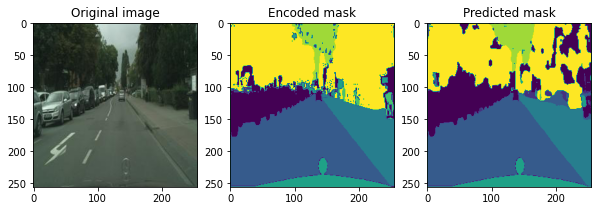

torch.Size([256, 256])


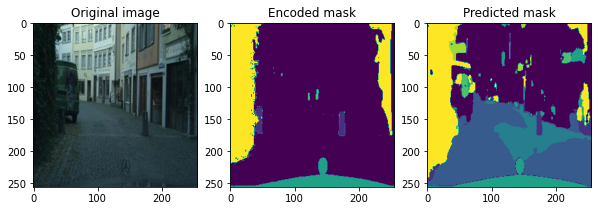

torch.Size([256, 256])


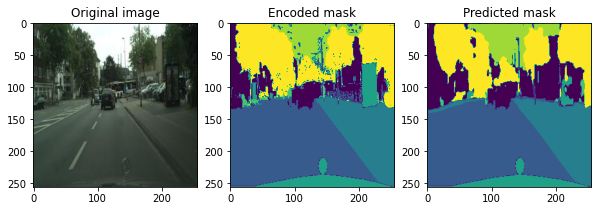

torch.Size([256, 256])


In [20]:
i=0
for batch in test1_dataloader:
    imagee, msok = batch
    mskie = transforms.Resize(256)
    mskl = mskie(msok).long()
    
    model.to(device)
    imagee = imagee.to(device=device)
    masku = mskl.to(device=device)
    p1 = model(imagee)
    p1 = p1[0].squeeze(dim=0).permute(1,2,0)
    p1 = torch.argmax(p1, dim=2)
    print(p1.shape)
    i+=1
    if i > 3:
        break
    imagee = torch.Tensor.cpu(imagee)
    p1 = torch.Tensor.cpu(p1)
    masku = torch.Tensor.cpu(masku)
       
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(imagee.squeeze(dim=0).permute(1,2,0))
    plt.title('Original image')
    plt.subplot(1,3,2)
    plt.imshow(masku.permute(1,2,0))
    plt.title('Encoded mask')
    plt.subplot(1,3,3)
    plt.imshow(p1)
    plt.title('Predicted mask')
    plt.show()   

### The end